In [16]:
library(tidyverse)
library(cowplot)


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [51]:
load("benchmark.RData")

benchmark <- benchmark %>%
    mutate(statistic = "LASSO",
           statistic = ifelse(grepl("evo", model), "chi2", statistic),
           statistic = ifelse(grepl("scones", model), "SKAT", statistic),
           selection = "LASSO",
           selection = ifelse(grepl("bic", model), "BIC", selection),
           selection = ifelse(grepl("aic", model), "AIC", selection),
           selection = ifelse(grepl("consistency", model), "cons", selection),
           selection = ifelse(grepl("scones", model), "SConES", selection),
           net = factor(toupper(net), levels = c("GS", "GM", "GI")))

We ran SConES in 4 different experimental settings, varying the statistic score used and the model selection:

- Statistic: chi2 and SKAT.
- Model selection: BIC, AIC and consistency.

We tested chi2 with all the model selection methods and SKAT +  consistency (original implementation, hence referred as SConES in the text).

# Results

Based on previous analyses, there are two dimensions worth paying attention to: how well we recovered the 100 causal SNPs, and how many false positives are we getting. Let's start with the size of the solution.

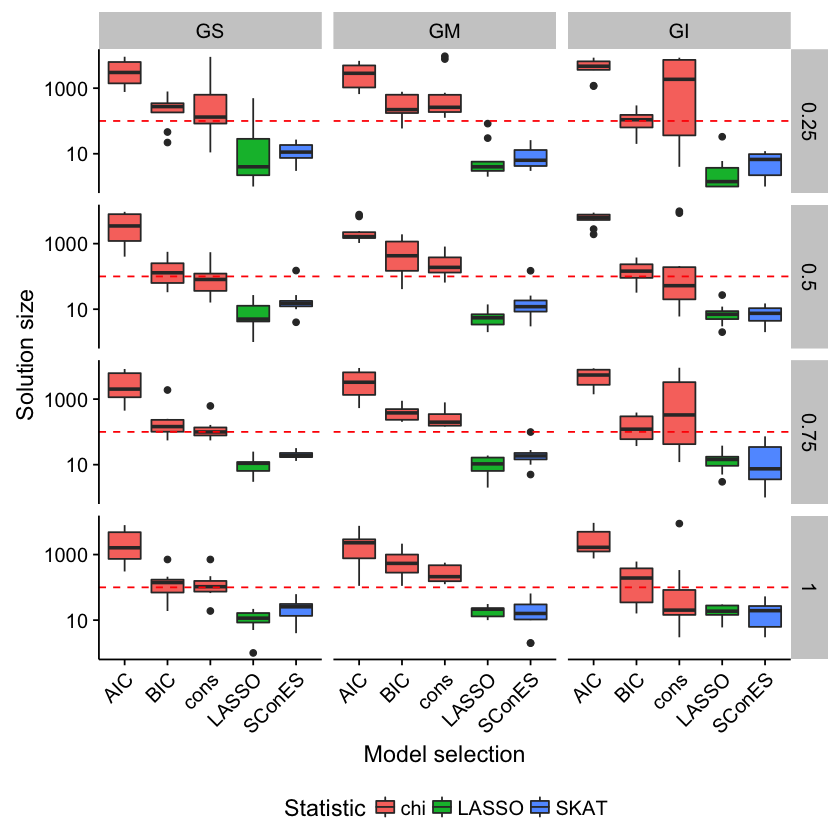

In [60]:
ggplot(benchmark, aes(x = selection, y = solutionSize, fill = algorithm)) + 
    geom_boxplot() +
    geom_hline(yintercept = 100, color = "red", linetype="dashed") +
    scale_y_log10() +
    facet_grid(h2 ~ net) +
    labs(x = "Model selection", y = "Solution size", fill = "Statistic") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

All the methods seem to be consistent in the order of magnitue of the solution size:
   
   - LASSO and SConES tend to pick solutions that are too small, consistenly around tens of SNPs.
   - Chi2 + (consistency | BIC) tend to be around 100.
   - Chi2 + AIC tend to be around 1000.
   
We can wonder how many of those are actually causal; we will look at the sensitivity for that.

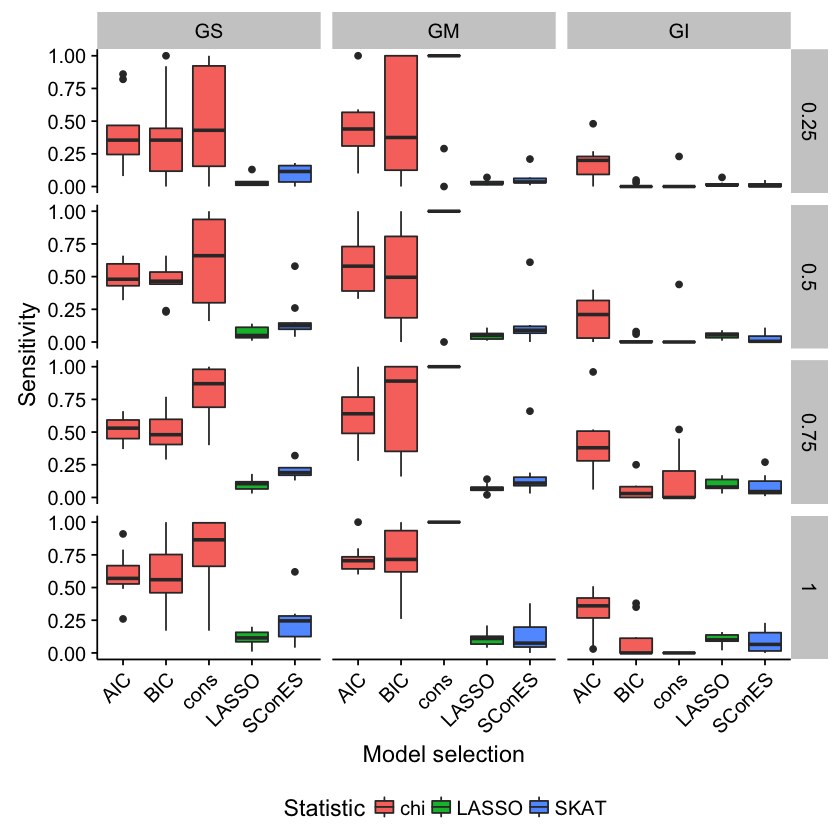

In [53]:
ggplot(benchmark, aes(x = selection, y = Sensitivity, fill = algorithm)) + 
    geom_boxplot() +
    facet_grid(h2 ~ net) +
    labs(x = "Model selection", fill = "Statistic") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

We see two groups of solutions. In the GS and GM networks, chi2 based approaches, specially consistency based ones, clearly outperform SConES and LASSO. This is particularly true in the GM network, combined with chi2 and consistenc: all the causal SNPs are recovered.

In the GI network, however, the results are not as good. It looks like a combination of chi2 and AIC are the ones with better performance, although that is likely due to the huge solution size of AIC (~1000 SNPs). We can further study it checking the precision, which measures the proportion of false positives in the solution.

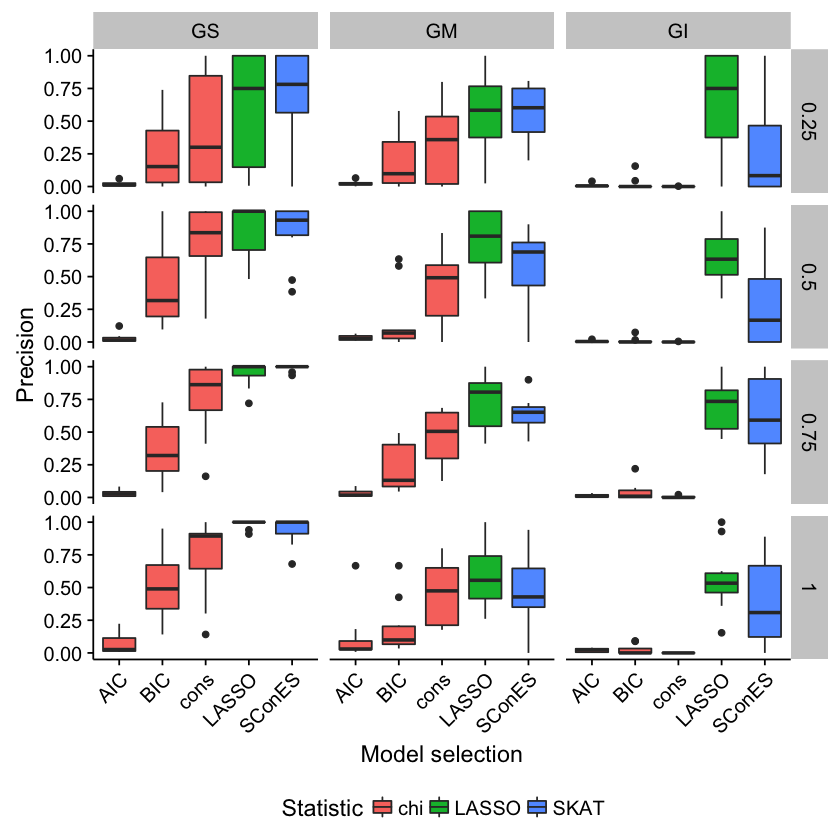

In [52]:
ggplot(benchmark, aes(x = selection, y = Precision, fill = algorithm)) + 
    geom_boxplot() +
    facet_grid(h2 ~ net) +
    labs(x = "Model selection", fill = "Statistic") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

AIC, and actually all chi2-based approaches are clearly underperforming in the GI network, possibly due to the fact that return bigger solutions. Possibly the higher sensitivity of the chi2 statistic altogether with the increased complexity of the network leads to too many false positives. Actually, SConES is also underperforming LASSO in the GI network.

On the bright side, precision is competitive, albeit worse, with SConES and LASSO in the GS and GM networks.

# Runtime

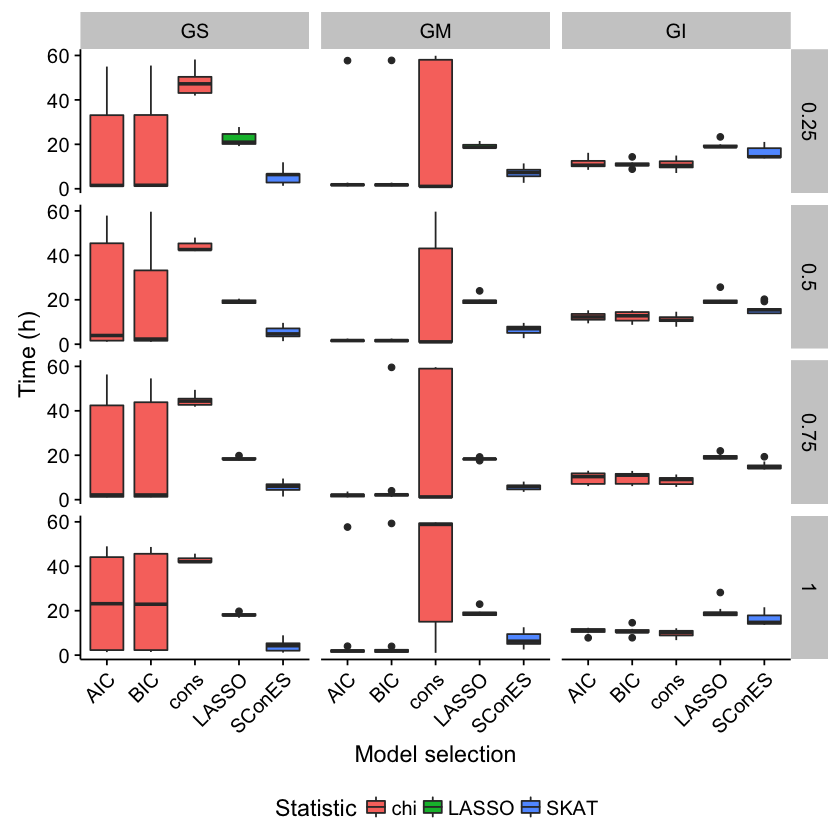

In [65]:
ggplot(benchmark, aes(x = selection, y = as.numeric(time), fill = algorithm)) + 
    geom_boxplot() +
    facet_grid(h2 ~ net) +
    labs(x = "Model selection", y = "Time (h)", fill = "Statistic") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

The new implementation of SConES looks inconsistent regarding runtimes. In general it looks slower than the EasyGWAS implementation, much more consistent, although in many instances is faster.

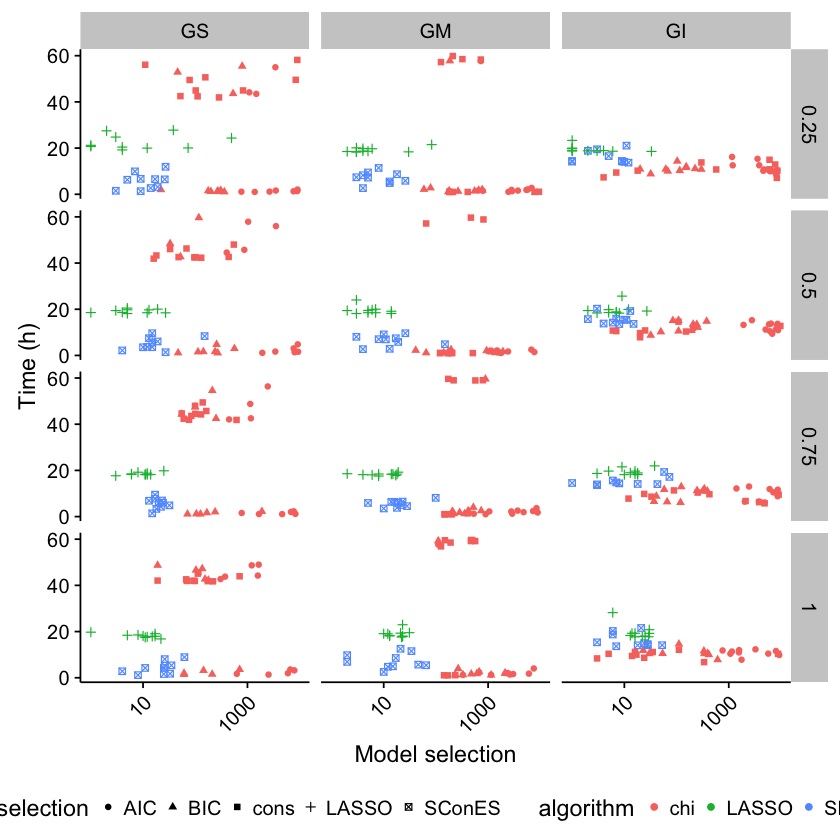

In [72]:
ggplot(benchmark, aes(x = solutionSize, y = as.numeric(time), 
                      color = algorithm, shape = selection)) + 
    geom_point() +
    scale_x_log10() +
    facet_grid(h2 ~ net) +
    labs(x = "Model selection", y = "Time (h)", fill = "Statistic") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "bottom")

The inconsistencies do not look correlated to the size of the solution.